# preprocess of recurrence

In [1]:
import os
import random
import itertools
import re
import collections

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from tqdm import tqdm
import warnings

import networkx as nx

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
    KFold,
)

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sampling
from imblearn.over_sampling import SMOTE

# 学習中


import config
import functions

SEED = config.SEED
THRESHOLD_YEARS = config.THRESHOLD_YEARS
THRESHOLD_MONTHS = config.THRESHOLD_MONTHS
INDEX_MICROARRAY = config.INDEX_MICROARRAY
TARGET_NAME = "RFS_OVER_{0}MONTHS".format(THRESHOLD_MONTHS)
functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [3]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [4]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

In [5]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)
df_MB.shape, df_MTST.shape

((1985, 35), (524, 35))

In [6]:
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR)
df_clinical.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_clinical.pkl"
)
df_MB.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MTST.pkl")

In [7]:
del df_patient, df_sample, df_clinical, df_MB, df_MTST

## 臨床データの読み込み

In [8]:
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MB.pkl")

## 遺伝子データの読み込み

In [9]:
"""
# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()
"""
# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()


dict_gene_expressions = dict(
    {
        "mrna_agilent_microarray": df_mrna_agilent_microarray,
        "mrna_agilent_microarray_zscores_ref_all_samples": df_mrna_agilent_microarray_zscores_ref_all_samples,
        "mrna_agilent_microarray_zscores_ref_diploid_samples": df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    }
)
dict_genes = {
    #    "cna": df_cna,
    #    "methylation_promoters_rrbs": df_methylation_promoters_rrbs,
    "mrna_agilent_microarray_zscores_ref_all_samples": df_mrna_agilent_microarray_zscores_ref_all_samples,
    "mrna_agilent_microarray_zscores_ref_diploid_samples": df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    "mrna_agilent_microarray": df_mrna_agilent_microarray,
}

# 目的変数の生成

モデルに入力する段階の仮定として、再発は既に判明している（データ取得時にはすでに手術を終えている状況であり、再発の有無についても見ているため）。
そこで、【再発年数が**n年**以内か、以後か】に注目し、RFS_MONTHSから目的変数を生成する。    
RFS_MONTHSは非再発者の最終フォローアップまでの月数も記録されているが、そちらはデータフレームを操作するときにRFS_STATUSからフィルタリングする。

In [10]:
functions.check(df_MB)

,feature,dtypes,nan,count,max,min,num_unique,unique,unique_counts
0,LYMPH_NODES_EXAMINED_POSITIVE,float64,76,1909,45.000000,0.000000,31,,
1,NPI,float64,1,1984,6.680000,1.000000,323,,
2,CELLULARITY,object,68,1917,nan,nan,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
3,COHORT,float64,0,1985,5.000000,1.000000,5,[1. 2. 3. 5. 4.],"{3.0: 763, 1.0: 526, 2.0: 288, 4.0: 238, 5.0: 170}"
4,INFERRED_MENOPAUSAL_STATE,object,5,1980,nan,nan,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"
5,SEX,object,0,1985,nan,nan,1,['Female'],{'Female': 1985}
6,INTCLUST,object,5,1980,nan,nan,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '7': 190, '5': 190, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
7,AGE_AT_DIAGNOSIS,float64,0,1985,96.290000,21.930000,1624,,
8,CLAUDIN_SUBTYPE,object,5,1980,nan,nan,7,['claudin-low' 'LumA' 'LumB' 'Normal' nan 'Her2' 'Basal' 'NC'],"{'LumA': 700, 'LumB': 475, 'Her2': 224, 'claudin-low': 218, 'Basal': 209, 'Normal': 148, 'NC': 6}"
9,THREEGENE,object,221,1764,nan,nan,4,['ER-/HER2-' 'ER+/HER2- High Prolif' nan 'ER+/HER2- Low Prolif' 'HER2+'],"{'ER+/HER2- Low Prolif': 640, 'ER+/HER2- High Prolif': 617, 'ER-/HER2-': 309, 'HER2+': 198}"


In [11]:
# RFS_STATUSのみにnullがあるため、そのデータについては患者データを削除する
df_MB.dropna(subset="RFS_STATUS", inplace=True)
# IDをindexにしたほうが都合がよいので変更
# df_MB.set_index("PATIENT_ID", inplace=True)
# 予測ラベルを扱いやすい形に変更
df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
    {"1:Recurred": 1, "0:Not Recurred": 0}
)

In [12]:
def make_target(target_months: int = THRESHOLD_MONTHS):
    df_MB[TARGET_NAME] = pd.cut(
        df_MB["RFS_MONTHS"], [0, target_months, np.inf], labels=[0, 1]
    )


make_target()
# 欠損値の削除
df_MB.dropna(inplace=True, subset=TARGET_NAME)

# 特徴エンジニアリング

## 臨床データ
予測の**層別化に必要な特徴を作成**する。

**層別化に必要な特徴**
- CLAUDIN_SUBTYPE
- NPI
- TUMOR_SIZE
- LYMPH_NODES_EXAMINED_POSITIVE

数値データは層別化のためにカテゴリ化を行う。
各カテゴリ化の根拠は以下の通り。
- NPI：( ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index )
- TUMOR_SIZE：乳癌のステージの定義( https://oshiete-gan.jp/breast/diagnosis/stages/detail.html )
- LYMPH_NODES_EXAMINED_POSITIVE：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

In [13]:
df_MB["NPI_CAT"] = pd.cut(
    df_MB.NPI,
    [0, 2.0, 2.4, 3.4, 5.4, np.inf],
    labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
)
df_MB["TUMOR_CAT"] = pd.cut(
    df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
)
df_MB["LYMPH_CAT"] = pd.cut(
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
    [-np.inf, 0, 3, np.inf],
    labels=["0", "1~3", "4~inf"],
)

## 遺伝子データ

**重複カラムのrename**

有識者の意見：『重複した遺伝子発現は別の遺伝子発現として扱うべき』とのことなので、重複する遺伝子特徴名はrenameする

参考：https://www.web-dev-qa-db-ja.com/ja/python/pandasdataframe%E5%90%8C%E3%81%98%E5%90%8D%E5%89%8D%E3%81%AE%E8%A4%87%E6%95%B0%E3%81%AE%E5%88%97%E3%81%AE%E5%90%8D%E5%89%8D%E3%82%92%E5%A4%89%E6%9B%B4/1046763736/

**欠損値の削除**

- 欠損値が多量 → 特徴を削除する。  
- 欠損値が少量 → 考え中...（削除 or 極端な値での補完）

### 特徴名のrename

In [14]:
df_gene_expressions = dict_gene_expressions["mrna_agilent_microarray"].copy()
# 重複特徴量の確認
print(
    "重複特徴名数（rename前）：",
    df_gene_expressions.columns[df_gene_expressions.columns.duplicated()]
    .value_counts()
    .sum(),
)

cols = pd.Series(df_gene_expressions.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [
        dup + "_" + str(i) if i != 0 else dup for i in range(sum(cols == dup))
    ]

# rename the columns with the cols list.
df_gene_expressions.columns = cols
# 重複特徴量の確認
print(
    "重複特徴名数（rename後）：",
    df_gene_expressions.columns[df_gene_expressions.columns.duplicated()]
    .value_counts()
    .sum(),
)

重複特徴名数（rename前）： 194
重複特徴名数（rename後）： 0


### 欠損値の削除

In [15]:
df_gene_expressions

Hugo_Symbol,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,CR749394,CD164,DB337918,MOBKL2A,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
MB-0000,9.738092,6.469688,5.457135,5.106495,5.652674,11.558869,8.340484,5.384699,5.648494,5.336235,5.468668,7.070649,5.477154,5.489805,5.318898,6.811309,5.440853,5.361170,5.823306,8.809831,6.790593,5.595347,6.141047,5.481023,6.499117,...,5.353135,5.198876,5.901473,5.610397,5.515762,5.213511,8.139151,10.232505,7.311327,9.677952,5.318426,5.635153,5.918239,5.295203,5.474224,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
MB-0002,9.013876,5.748717,5.699735,5.419119,5.611212,6.199492,8.341091,5.490558,5.789506,5.700974,5.495295,6.098949,5.589824,5.055598,5.489397,6.952007,5.545206,5.579463,6.341935,9.307305,6.132436,5.328097,6.400910,5.531249,7.178274,...,4.888335,5.615278,6.447777,5.950548,5.502117,5.124030,8.261487,10.186566,6.324112,8.895600,5.345262,6.281727,5.515844,5.442257,5.303871,5.384794,5.285060,7.612797,7.988643,5.194247,6.328059,5.469445,6.938685,5.231857,5.604560
MB-0005,7.963493,5.553056,5.472386,5.265556,5.793398,6.489781,8.862815,5.538854,5.566713,7.233671,5.537530,6.964546,5.255454,5.374815,5.668776,6.480061,5.790445,5.462634,5.807004,8.477327,5.572601,5.539776,8.575001,5.562090,6.469047,...,5.313808,5.508167,6.076896,5.747801,5.368297,5.371385,7.731911,9.954702,7.222594,8.972083,5.420388,5.404494,5.350242,5.368716,5.370394,5.336455,5.452393,6.619220,8.044471,5.306294,6.306927,5.362207,7.397672,5.372138,5.645597
MB-0006,8.177157,5.391160,5.529795,5.011812,5.807604,5.319779,8.693784,5.430685,5.539252,6.124384,6.657355,6.409554,5.289307,5.299305,5.112324,5.987913,5.393475,5.282728,5.985588,8.101386,5.808433,5.345124,9.164529,5.336013,6.487679,...,5.228991,5.324400,5.650472,5.579526,5.303998,5.351482,8.301195,10.088769,7.053031,8.664307,5.370416,5.480761,5.650978,5.295628,5.694697,5.663304,5.529928,6.966482,7.527300,5.197607,6.515638,5.309927,6.175716,5.586521,5.354582
MB-0008,8.050127,5.530582,5.303667,5.149618,5.934570,8.787583,8.055626,5.239388,5.646685,7.155642,5.878104,5.798117,5.297733,5.610297,5.141883,6.675580,6.598310,5.328773,6.200995,9.301414,6.182025,5.384272,5.904271,5.457066,6.426740,...,5.322069,5.136661,6.403137,5.904885,5.473140,5.460753,8.007261,11.244345,5.926732,8.141539,5.217030,5.442109,5.527755,5.192858,5.474929,5.799346,5.597297,6.942461,8.115359,5.254136,6.323751,5.518767,6.272568,5.204630,5.030636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7295,8.589374,6.002483,5.116077,4.996112,5.802742,5.474550,8.251690,5.373561,5.546402,6.532649,5.535139,6.282020,5.440358,5.637957,5.172188,6.486128,6.074573,5.281556,6.058330,8.722802,5.891944,5.408865,6.315133,5.545770,6.707501,...,5.394435,5.324246,6.132406,5.471503,5.372043,5.364380,8.455392,10.303605,6.686198,9.987552,5.354638,5.529167,5.722099,5.240904,5.521765,5.488675,5.461927,7.536208,8.314500,5.337300,6.278034,5.426899,6.923887,5.251896,5.168953
MB-7296,8.402660,6.104059,5.443955,5.224513,5.256086,6.659117,8.641838,5.488370,5.522964,7.102716,5.353956,5.546199,5.289827,5.272168,5.424468,6.491748,5.865518,5.564988,6.132467,8.814733,6.236368,5.237184,6.257710,5.360478,6.223216,...,5.304696,5.396539,6.221306,5.315972,5.300309,5.268524,8.523291,11.353435,6.623708,8.441388,5.443857,5.644035,5.453321,5.171671,5.441341,5.375910,5.393811,7.709596,8.105717,5.397931,6.325456,5.217163,6.524268,5.505418,5.252479
MB-7297,8.236918,5.402870,5.533742,5.468793,5.571897,5.439574,8.979375,5.283460,5.804127,6.593890,5.353883,5.705768,5.531300,5.313886,5.212158,6.906297,6.116738,5.132988,6.03

欠損値が多い特徴個数： 0
欠損値が少ない特徴個数： 8


<AxesSubplot:xlabel='Hugo_Symbol'>

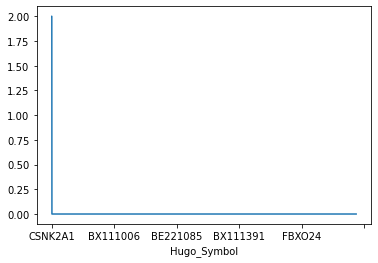

In [16]:
print(
    "欠損値が多い特徴個数：",
    (df_gene_expressions.isnull().sum() > df_gene_expressions.shape[0] // 10).sum(),
)
print(
    "欠損値が少ない特徴個数：",
    (
        (df_gene_expressions.isnull().sum() < +df_gene_expressions.shape[0] // 10)
        & (df_gene_expressions.isnull().sum() > 0)
    ).sum(),
)
series_gene_expressions_name = df_gene_expressions.isnull().sum().sort_values()[::-1]
series_gene_expressions_name.plot()

In [17]:
# 多数の欠損値を持つ特徴
many_null_gene_expressions_names = series_gene_expressions_name[
    df_gene_expressions.isnull().sum() > df_gene_expressions.shape[0] // 10
].index
# 少数の欠損値を持つ特徴
few_null_gene_expressions_names = series_gene_expressions_name[
    (df_gene_expressions.isnull().sum() <= df_gene_expressions.shape[0] // 10)
    & (df_gene_expressions.isnull().sum() > 0)
]
# 少数の欠損値の遺伝子発現を持つ患者ID
list_patient_id_contains_null_expressions = list()
for name in few_null_gene_expressions_names.index:
    for patient_id in df_gene_expressions[df_gene_expressions[name].isnull()].index:
        list_patient_id_contains_null_expressions.append(patient_id)

# 多数の欠損値を持つ特徴の削除
df_gene_expressions.drop(many_null_gene_expressions_names, axis=1, inplace=True)
# 少数の欠損値の遺伝子発現を持つ患者の削除
df_gene_expressions.drop(list_patient_id_contains_null_expressions, inplace=True)

In [18]:
df_gene_expressions.shape

(1894, 24368)

# 臨床データと遺伝子データの結合

患者の必要な特徴を含む臨床データと遺伝子データを結合する。

## 臨床データ

### 必要な特徴

**目的変数**
- RFS_OVER_nMONTHS  

**層別化対象候補**
- CLAUDIN_SUBTYPE
- NPI_CAT
- TUMOR_CAT
- LYMPH_CAT

## 遺伝子データ
遺伝子データは全てのデータを結合する。

In [19]:
left_columns = [
    "RFS_STATUS",
    TARGET_NAME,
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

df_merged = pd.merge(
    df_MB[left_columns],
    df_gene_expressions,
    left_index=True,
    right_index=True,
)

functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR)
df_merged.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_merged.pkl")

In [20]:
df_gene_expressions

Hugo_Symbol,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,CR749394,CD164,DB337918,MOBKL2A,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
MB-0000,9.738092,6.469688,5.457135,5.106495,5.652674,11.558869,8.340484,5.384699,5.648494,5.336235,5.468668,7.070649,5.477154,5.489805,5.318898,6.811309,5.440853,5.361170,5.823306,8.809831,6.790593,5.595347,6.141047,5.481023,6.499117,...,5.353135,5.198876,5.901473,5.610397,5.515762,5.213511,8.139151,10.232505,7.311327,9.677952,5.318426,5.635153,5.918239,5.295203,5.474224,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
MB-0002,9.013876,5.748717,5.699735,5.419119,5.611212,6.199492,8.341091,5.490558,5.789506,5.700974,5.495295,6.098949,5.589824,5.055598,5.489397,6.952007,5.545206,5.579463,6.341935,9.307305,6.132436,5.328097,6.400910,5.531249,7.178274,...,4.888335,5.615278,6.447777,5.950548,5.502117,5.124030,8.261487,10.186566,6.324112,8.895600,5.345262,6.281727,5.515844,5.442257,5.303871,5.384794,5.285060,7.612797,7.988643,5.194247,6.328059,5.469445,6.938685,5.231857,5.604560
MB-0005,7.963493,5.553056,5.472386,5.265556,5.793398,6.489781,8.862815,5.538854,5.566713,7.233671,5.537530,6.964546,5.255454,5.374815,5.668776,6.480061,5.790445,5.462634,5.807004,8.477327,5.572601,5.539776,8.575001,5.562090,6.469047,...,5.313808,5.508167,6.076896,5.747801,5.368297,5.371385,7.731911,9.954702,7.222594,8.972083,5.420388,5.404494,5.350242,5.368716,5.370394,5.336455,5.452393,6.619220,8.044471,5.306294,6.306927,5.362207,7.397672,5.372138,5.645597
MB-0006,8.177157,5.391160,5.529795,5.011812,5.807604,5.319779,8.693784,5.430685,5.539252,6.124384,6.657355,6.409554,5.289307,5.299305,5.112324,5.987913,5.393475,5.282728,5.985588,8.101386,5.808433,5.345124,9.164529,5.336013,6.487679,...,5.228991,5.324400,5.650472,5.579526,5.303998,5.351482,8.301195,10.088769,7.053031,8.664307,5.370416,5.480761,5.650978,5.295628,5.694697,5.663304,5.529928,6.966482,7.527300,5.197607,6.515638,5.309927,6.175716,5.586521,5.354582
MB-0008,8.050127,5.530582,5.303667,5.149618,5.934570,8.787583,8.055626,5.239388,5.646685,7.155642,5.878104,5.798117,5.297733,5.610297,5.141883,6.675580,6.598310,5.328773,6.200995,9.301414,6.182025,5.384272,5.904271,5.457066,6.426740,...,5.322069,5.136661,6.403137,5.904885,5.473140,5.460753,8.007261,11.244345,5.926732,8.141539,5.217030,5.442109,5.527755,5.192858,5.474929,5.799346,5.597297,6.942461,8.115359,5.254136,6.323751,5.518767,6.272568,5.204630,5.030636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7295,8.589374,6.002483,5.116077,4.996112,5.802742,5.474550,8.251690,5.373561,5.546402,6.532649,5.535139,6.282020,5.440358,5.637957,5.172188,6.486128,6.074573,5.281556,6.058330,8.722802,5.891944,5.408865,6.315133,5.545770,6.707501,...,5.394435,5.324246,6.132406,5.471503,5.372043,5.364380,8.455392,10.303605,6.686198,9.987552,5.354638,5.529167,5.722099,5.240904,5.521765,5.488675,5.461927,7.536208,8.314500,5.337300,6.278034,5.426899,6.923887,5.251896,5.168953
MB-7296,8.402660,6.104059,5.443955,5.224513,5.256086,6.659117,8.641838,5.488370,5.522964,7.102716,5.353956,5.546199,5.289827,5.272168,5.424468,6.491748,5.865518,5.564988,6.132467,8.814733,6.236368,5.237184,6.257710,5.360478,6.223216,...,5.304696,5.396539,6.221306,5.315972,5.300309,5.268524,8.523291,11.353435,6.623708,8.441388,5.443857,5.644035,5.453321,5.171671,5.441341,5.375910,5.393811,7.709596,8.105717,5.397931,6.325456,5.217163,6.524268,5.505418,5.252479
MB-7297,8.236918,5.402870,5.533742,5.468793,5.571897,5.439574,8.979375,5.283460,5.804127,6.593890,5.353883,5.705768,5.531300,5.313886,5.212158,6.906297,6.116738,5.132988,6.03

In [21]:
df_MB[left_columns]

,RFS_STATUS,RFS_OVER_60MONTHS,CLAUDIN_SUBTYPE,NPI_CAT,TUMOR_CAT,LYMPH_CAT
PATIENT_ID,,,,,,
MB-0000,0,1,claudin-low,5.4~inf,20~50,4~inf
MB-0002,0,1,LumA,3.4~5.4,0~20,0
MB-0005,1,1,LumB,3.4~5.4,0~20,1~3
MB-0006,0,1,LumB,3.4~5.4,20~50,1~3
MB-0008,1,0,LumB,5.4~inf,20~50,4~inf
...,...,...,...,...,...,...
MB-7295,0,1,LumA,3.4~5.4,20~50,1~3
MB-7296,1,0,LumB,3.4~5.4,0~20,1~3
MB-7297,1,1,LumB,5.4~inf,20~50,4~inf


# 再発者の抽出

再発者のみを対象とするため、再発者を抽出する

In [22]:
df_recurrenced = df_merged[df_merged["RFS_STATUS"] == 1].drop("RFS_STATUS", axis=1)
df_recurrenced.shape

# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR)
df_recurrenced.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

## データ分割

訓練データ、検証データ、テストデータに層化分割する   
比率は(train, val, test)=(0.81, 0.09, 0.1)  
CVは行わずに通常のholdoutで検証は行う（特徴選択を毎度実施するのが厄介なため）


In [23]:
# データ分割のためのクラス
# pythonのミュータブルオブジェクトの外部操作を防ぐためにcopy()の使用&private化
class SplitDataFrame:
    def __init__(self, df):
        self.__df = df.copy()
        self.__train_size = 0.9

        self.__df_train_val = None
        self.__df_train = None
        self.__df_val = None
        self.__df_test = None

        self.__X_train_val = None
        self.__y_train_val = None
        self.__X_train = None
        self.__y_train = None
        self.__X_val = None
        self.__y_val = None
        self.__X_test = None
        self.__y_test = None

    def split_train_val_test(self):
        # train & test
        self.__df_train_val, self.__df_test = train_test_split(
            self.__df,
            train_size=self.__train_size,
            stratify=self.__df[TARGET_NAME],
            random_state=SEED,
        )
        # train & val
        self.__df_train, self.__df_val = train_test_split(
            self.__df_train_val,
            train_size=self.__train_size,
            stratify=self.__df_train_val[TARGET_NAME],
            random_state=SEED,
        )

    def split_X_y(self):
        self.__X_train, self.__y_train = (
            self.__df_train.drop(TARGET_NAME, axis=1),
            self.__df_train[TARGET_NAME],
        )
        self.__X_val, self.__y_val = (
            self.__df_val.drop(TARGET_NAME, axis=1),
            self.__df_val[TARGET_NAME],
        )
        self.__X_train_val, self.__y_train_val = (
            self.__df_train_val.drop(TARGET_NAME, axis=1),
            self.__df_train_val[TARGET_NAME],
        )
        self.__X_test, self.__y_test = (
            self.__df_test.drop(TARGET_NAME, axis=1),
            self.__df_test[TARGET_NAME],
        )

    def get_train_val_Xy(self):
        return self.__X_train_val.copy(), self.__y_train_val.copy()

    def get_train_Xy(self):
        return self.__X_train.copy(), self.__y_train.copy()

    def get_val_Xy(self):
        return self.__X_val.copy(), self.__y_val.copy()

    def get_test_Xy(self):
        return self.__X_test.copy(), self.__y_test.copy()

# 特徴選択

特徴数が多いため、特徴数を削減する

**目安**
サンプル数が767件であり、8割程度が学習に使用できる(train : val : test = 0.9*0.9 : 0.9*0.1 : 0.1)ため、学習データの1割程度の60個を選択後上限数の目安とする

In [24]:
# 適用する処理毎にdfをまとめたclass
class PreprocessDataFrame:
    def __init__(self, df_raw):
        self.__raw = df_raw.copy()
        self.__preprocessed = None
        self.__preprocess_methods = list()

    def get_preprocessed_df(self):
        return self.__preprocessed.copy()

    def get_preprocess_methods(self):
        return self.__preprocess_methods.copy()

    # feature_selection
    def set_variance_threshold(self, df):
        """
        分散によるフィルターで特徴を選択したdf
        """
        self.__preprocess_methods.append("variance_threshold")
        self.__preprocessed = df

    def set_mrmr(self, df):
        """
        mrmrで特徴を選択したdf
        """
        self.__preprocess_methods.append("mrmr")
        self.__preprocessed = df

    # scaling
    def set_std(self, df):
        """
        standarization
        """
        self.__preprocess_methods.append("std")
        self.__preprocessed = df
        # scaling

    def set_norm(self, df):
        """
        normalization
        """
        self.__preprocess_methods.append("norm")
        self.__preprocessed = df

    # sampling
    def set_smote(self, df):
        """
        smote
        """
        self.__preprocess_methods.append("smote")
        self.__preprocessed = df

## 手法毎に前処理を行う関数の実装


In [25]:
def save_preprocessed_df(
    list_train: list(),
    list_val: list(),
    list_train_val: list(),
    list_test: list(),
    save_file_path: str = ".",
    save_file_name: str = "sample",
):
    """
    params
    list_train: [X_train, y_train]
    list_val: [X_val, y_val]
    list_train_val: [X_train_val, y_train_val]
    list_test: [X_val, y_val]
    """
    functions.make_dir("{0}/train".format(save_file_path))
    list_train[0].to_pickle(
        "{0}/train/X_{1}.pkl".format(save_file_path, save_file_name)
    )
    list_train[1].to_pickle(
        "{0}/train/y_{1}.pkl".format(save_file_path, save_file_name)
    )
    functions.make_dir("{0}/val".format(save_file_path))
    list_val[0].to_pickle("{0}/val/X_{1}.pkl".format(save_file_path, save_file_name))
    list_val[1].to_pickle("{0}/val/y_{1}.pkl".format(save_file_path, save_file_name))

    functions.make_dir("{0}/train_val".format(save_file_path))
    list_train_val[0].to_pickle(
        "{0}/train_val/X_{1}.pkl".format(save_file_path, save_file_name)
    )
    list_train_val[1].to_pickle(
        "{0}/train_val/y_{1}.pkl".format(save_file_path, save_file_name)
    )
    functions.make_dir("{0}/test".format(save_file_path))
    list_test[0].to_pickle("{0}/test/X_{1}.pkl".format(save_file_path, save_file_name))
    list_test[1].to_pickle("{0}/test/y_{1}.pkl".format(save_file_path, save_file_name))

In [27]:
def preprocess_df(
    df: pd.DataFrame(),
    feature_selection_method: str = None,
    scaling_method: str = None,
    sampling_method: str = None,
    save_file_path: str = None,
    save_file_name: str = None,
    is_save: bool = False,
):
    _df = df.copy()

    # データが少なすぎる場合は特徴選択しない
    if _df.shape[0] > 99:
        # データ分割

        sp = SplitDataFrame(_df)
        sp.split_train_val_test()
        sp.split_X_y()

        X_train, y_train = sp.get_train_Xy()
        X_val, y_val = sp.get_val_Xy()
        X_train_val, y_train_val = sp.get_train_val_Xy()
        X_test, y_test = sp.get_test_Xy()

        # class初期化
        pd_train = PreprocessDataFrame(X_train)
        pd_val = PreprocessDataFrame(X_val)
        pd_train_val = PreprocessDataFrame(X_train_val)
        pd_test = PreprocessDataFrame(X_test)

        # feature selection
        if feature_selection_method == "none":
            pass
        elif feature_selection_method == "variance_threshold":
            # 分散値上位の特徴を抽出
            features = (
                X_train.var().sort_values().tail(X_train.shape[0] // 10).index
            )  # 学習データの1/10サイズ
            pd_train.set_variance_threshold(X_train[features])
            pd_val.set_variance_threshold(X_val[features])

            features = (
                X_train_val.var()
                .sort_values()
                .tail(X_train_val.shape[0] // 10)
                .index  # 学習データの1/10サイズ
            )
            pd_train_val.set_variance_threshold(X_train_val[features])
            pd_test.set_variance_threshold(X_test[features])
        elif feature_selection_method == "mrmr":
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=X_train.shape[0] // 10,  # 学習データの1/10サイズ
                show_progress=False,
            )
            pd_train.set_mrmr(X_train[features])
            pd_val.set_mrmr(X_val[features])

            features = mrmr.mrmr_classif(
                X=X_train_val,
                y=y_train_val,
                K=X_train_val.shape[0] // 10,  # 学習データの1/10サイズ
                show_progress=False,
            )
            pd_train_val.set_mrmr(X_train_val[features])
            pd_test.set_mrmr(X_test[features])
        else:
            print("undefined feature_selection_method")
            return

        # scaling
        if scaling_method == "none":
            pass
        elif scaling_method == "std":
            X_train, X_val = functions.transform_std(
                pd_train.get_preprocessed_df(), pd_val.get_preprocessed_df()
            )
            X_train_val, X_test = functions.transform_std(
                pd_train_val.get_preprocessed_df(), pd_test.get_preprocessed_df()
            )
            pd_train.set_std(X_train)
            pd_val.set_std(X_val)
            pd_train_val.set_std(X_train_val)
            pd_test.set_std(X_test)
        elif scaling_method == "norm":
            X_train, X_val = functions.transform_norm(
                pd_train.get_preprocessed_df(), pd_val.get_preprocessed_df()
            )
            X_train_val, X_test = functions.transform_norm(
                pd_train_val.get_preprocessed_df(), pd_test.get_preprocessed_df()
            )
            pd_train.set_norm(X_train)
            pd_val.set_std(X_val)
            pd_train_val.set_std(X_train_val)
            pd_test.set_std(X_test)
        else:
            print("undefined scaling_method")
            return

        # sampling
        if sampling_method == "none":
            pass
        elif sampling_method == "smote":
            smote = SMOTE(sampling_strategy="minority", random_state=SEED)
            X_train, y_train = smote.fit_resample(
                pd_train.get_preprocessed_df(), y_train
            )
            smote = SMOTE(sampling_strategy="minority", random_state=SEED)
            X_train_val, y_train_val = smote.fit_resample(
                pd_train_val.get_preprocessed_df(), y_train_val
            )
            pd_train.set_smote(X_train)
            pd_train_val.set_smote(X_train_val)
        else:
            print("undefined sampling_method")
            return

        """
        print("applied preprocess (train): ", pd_train.get_preprocess_methods())
        print("shape (train): ", pd_train.get_preprocessed_df().shape, y_train.shape)
        print("applied preprocess (val): ", pd_val.get_preprocess_methods())
        print("shape (val): ", pd_val.get_preprocessed_df().shape, y_val.shape)
        print("applied preprocess (train_val): ", pd_train_val.get_preprocess_methods())
        print(
            "shape (train_val): ",
            pd_train_val.get_preprocessed_df().shape,
            y_train_val.shape,
        )
        print("applied preprocess (test): ", pd_test.get_preprocess_methods())
        print("shape (test): ", pd_test.get_preprocessed_df().shape, y_test.shape)
        """
        # 保存
        if is_save:
            save_preprocessed_df(
                list_train=[pd_train.get_preprocessed_df(), y_train],
                list_val=[pd_val.get_preprocessed_df(), y_val],
                list_train_val=[pd_train_val.get_preprocessed_df(), y_train_val],
                list_test=[pd_test.get_preprocessed_df(), y_test],
                save_file_path=save_file_path,
                save_file_name=save_file_name,
            )


is_save = True

# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

feature_selection_methods = ["variance_threshold", "mrmr"]

scaling_methods = ["std", "norm"]

sampling_methods = ["none", "smote"]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )

    df = df_recurrenced.drop(subgroup_columns, axis=1)
    output_file_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
        "ALL_DATA",
        preprocess_order,
    )
    preprocess_df(
        df=df,
        feature_selection_method=feature_selection_method,
        scaling_method=scaling_method,
        sampling_method=sampling_method,
        save_file_path=output_file_path,
        save_file_name="all_data",
        is_save=is_save,
    )  # データ全体への特徴選択
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                subgroup_columns, axis=1
            )
            output_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
            )
            functions.make_dir(output_file_path)
            preprocess_df(
                df,
                feature_selection_method=feature_selection_method,
                scaling_method=scaling_method,
                sampling_method=sampling_method,
                save_file_path=output_file_path,
                save_file_name=subgroup,
                is_save=is_save,
            )

8it [1:27:21, 655.25s/it] 
